# Tensor Network Representations of Parton Wave functions
## Term project #6
### Tensor networks 2025
#### Philipp Heinrich, Schäffer Bálint

In [1]:
using JLD2
#save("project_vars.jld2", "MPS_iter", MPS_iter, "k_vec", k_vec, "mps_jw", mps_jw)
@load "project_vars.jld2" MPS_iter k_vec mps_jw

3-element Vector{Symbol}:
 :MPS_iter
 :k_vec
 :mps_jw

## Steps
0. Figure out the fermionic / spin representations ($S\rightarrow c\rightarrow\sigma$)
1. Construct fermionic vacuum state as MPS and $d_k^\dagger$ as MPO and construct the Fermi sea
2. Plot the entanglement entropy
3. Constuct Wannier orbitals and apply them, plot the entanglement entropy
4. Do the same using the left-meets-right method
5. Apply Gutzwiller projection and compute ground-state energy using DMRG
6. Compute the spin-spin correlation function and compare to exact values
7. Prepare a presentation
8. Seem like we know what we're doing, get a good grade

## _(a)_ The Haldane-Shastry model
$$H_\mathrm{HS}=\sum_{p<q}\frac{\pi^2\vec{S}_p\cdot\vec{S}_q}{N^2\sin^2{\frac{\pi}{N}(p-q)}}$$
* $N=32$
* Abrikosov Fermion representation: $S_j^a=\frac{1}{2}\sum_{\alpha\beta}c_{\alpha a}^\dagger\tau_{\alpha\beta}^ac_{j\beta}$
* Separate the sites into spin-up and spin-down sites: $\sum_{j=1}^N\sum_{\alpha=\uparrow,\downarrow}=\sum_{l=1}^{2N}$
* Jordan-Wigner transformation: $c_l^\dagger=\sigma_{l<}^z\sigma_l^+$ with $\sigma_{l<}^z=\Pi_{i=1}^{l-1}\sigma_i^z$
* The fermionic vacuum: $\ket{0}\rightarrow\ket{\downarrow...\downarrow}$
### Preparing the vacuum state

In [15]:
using LinearAlgebra

id = I(2)  # identity matrix for spin-1/2
sz = [1 0; 0 -1]  # spin-z operator
sp = [0 1; 0 0]  # spin raising operator
sm = [0 0; 1 0]  # spin lowering operator

N = 32
mps = Vector{Array{Complex, 3}}(undef, 2N)
for i in 1:2N
    # easiest representation of a single site MPS for spinless fermions
    mps[i] = zeros(1,2,1)
    if mod(i, 2) == 1
        mps[i][1, 1, 1] = 1.0  # occupied state
    else
        mps[i][1, 2, 1] = 1.0  # unoccupied state
    end
end

# construct the MPS for the JOrdan-Wigner transformed system
mps_jw = Vector{Array{Complex, 3}}(undef, 2N)
for i in 1:2N
    mps_jw[i] = zeros(1, 2, 1)
    mps_jw[i][1, 2, 1] = 1.0  # spin down = (0,1)
end

- $\ket{\downarrow}=\begin{pmatrix} 0 \\ 1 \end{pmatrix};~ \ket{\uparrow}=\begin{pmatrix} 1 \\ 0 \end{pmatrix}$
- $\sigma^+=\begin{pmatrix} 0&1\\0&0 \end{pmatrix};~ \sigma^z=\begin{pmatrix} 1&0\\0&-1 \end{pmatrix}$
- As for the Parton creation operators:
- fermion rep: $d_k^\dagger=\begin{pmatrix}0&1\end{pmatrix}\left[ \prod_{l=1}^{2N} \begin{pmatrix} 1&0\\A_{kl}c_l^\dagger&1 \end{pmatrix} \right]\begin{pmatrix}1\\0\end{pmatrix}$
- Jordan-Wigner transformation: $d_k^\dagger=\begin{pmatrix}0&1\end{pmatrix}\left[ \prod_{l=1}^{2N} \begin{pmatrix} 1&0\\A_{kl}\sigma_l^+&\sigma_l^z \end{pmatrix} \right]\begin{pmatrix}1\\0\end{pmatrix}$
    - for H-S model: $d_{m\alpha}^\dagger=N^{-1/2}\sum_{j=1}^Ne^{-i\cdot(jm)}c_{j\alpha}^\dagger=\sum_{j=1}^N A_{m,j\alpha}c_{j\alpha}^\dagger$
    - As an MPO: $d_{k\alpha}^\dagger=\begin{pmatrix}0&1\end{pmatrix}\left[ \prod_{l=1}^{2N} \begin{pmatrix} 1&0\\A_{kl\alpha}\sigma_l^+&\sigma_l^z \end{pmatrix} \right]\begin{pmatrix}1\\0\end{pmatrix}$
    - with $A_{kl\alpha}=\begin{cases} 0~~~\mathrm{mod}_2l=\alpha \\ N^{-1/2}e^{-i\cdot(k\cdot(l+1-\alpha)/2)} \end{cases}$
- If we denote $(j=1,\alpha=\uparrow)\to(l=1)$ and use $(\alpha=\uparrow)=0,(\alpha=\downarrow)=1$, then $l(j,\alpha)=2j-1+\alpha$

In [2]:
import tn_julia: contract, updateLeft

function A_klalpha(k::Float64, l::Int, alpha::Int)
    if mod(l,2) == alpha
        return 0.0  # A_{kl\alpha} = 0 if l is even and alpha is 0, or l is odd and alpha is 1
    else
        # A_{kl\alpha} = N^{-1/2}e^{-i\cdot(k\cdot(l+1-\alpha)/2)}
        return (1/sqrt(N)) * exp(-im * k * (l + 1 - alpha) / 2)
    end
end

function mpo_dkalpha(k::Float64, alpha::Int, l_vec::Int)
    mpo_dk = Vector{Array{Complex, 4}}(undef, l_vec)
    for l in 1:l_vec
        mpo_dk[l] = zeros(Complex, 2, 2, 2, 2)  # MPO for d_k operator
        mpo_dk[l][1, :, 1, :] = id # identity operator
        mpo_dk[l][2, :, 2, :] = sz # sigma_z
        mpo_dk[l][2, :, 1, :] = A_klalpha(k,l,alpha) .* sp # sigma^+
    end
    mpo_dk[1] = contract([0 1], [2], mpo_dk[1], [1])
    mpo_dk[l_vec] = permutedims(contract(mpo_dk[l_vec], [3], [1 0], [2]), (1,2,4,3))
    return mpo_dk
end

mpo_dkalpha (generic function with 1 method)

In [23]:
A_klalpha(-2*pi*7/32, 1, 0)
test = mpo_dkalpha(-2*pi*7/32, 0, 64)

mps_jw[1]


1×2×1 Array{Complex, 3}:
[:, :, 1] =
 0.0+0.0im  1.0+0.0im

In [20]:
applyMPO(mps_jw, test, 100)[1]


1×2×2 Array{Complex, 3}:
[:, :, 1] =
 0.0+0.0im  0.984251+0.0im

[:, :, 2] =
 -0.0344874-0.17338im  0.0+0.0im

### Applying the creation operators
- The occupied momenta:
$$\vec{k} = \frac{2\pi}{N}\begin{cases} 0, \pm 1, ..., \frac{N}{4}~~~\mathrm{mod}_4N=0 \\ 0, \pm 1, \pm \frac{N-2}{4}~~~\mathrm{mod}_4N=2 \end{cases}$$
- Constructing the _unprojected_ Fermi-sea: $\ket{FS}=\prod_{k\in \vec{k}}\prod_{\alpha=\uparrow,\downarrow}d_{k\alpha}^\dagger\ket{0}$
- Bond dim. cutoff: $D_\mathrm{max}=100$
- at each update: left canonical form without truncation, then right canonical form with truncation

In [ ]:
import tn_julia: svdleft, svdright, identity as tn_identity, leftcanonical, rightcanonical, leftcanonical!, rightcanonical!
using Dates

function applyMPO(mps::Vector{Array{Complex, 3}}, mpo::Vector{Array{Complex, 4}}, Nkeep::Int=Inf)
    result = Vector{Array{Complex, 3}}(undef, length(mps))
    for i in 1:length(mps)
        mps_new = contract(mps[i], [2], mpo[i], [4])
        # combine legs (1, 3) and (2, 5)
        id14 = tn_identity(mps_new, 1, mps_new, 3)
        id23 = tn_identity(mps_new, 2, mps_new, 5)
        mps_new = contract(mps_new, [1, 3], id14, [1, 2])
        mps_new = contract(mps_new, [1, 3], id23, [1, 2])
        result[i] = permutedims(mps_new, (2, 1, 3))
    end
    #TODO change leftcanonical to a QR decomposition instead of SVD
    leftcanonical!(result)
    rightcanonical!(result; Nkeep=Nkeep)
    return result
end

applyMPO (generic function with 2 methods)

In [ ]:
applyMPO(mps_jw, )

In [7]:
k_vec = sort(2*pi/N.*(div(-N+1,4):div(N,4)), by=abs)
Dmax = 100  # bond dimension cutoff

MPS_iter = Array{Array{Complex, 3}, 2}(undef, 2 * length(k_vec), 2N)
mps = mps_jw  # start with the Jordan-Wigner MPS
for (i,k) in enumerate(k_vec)
    for alpha in 0:1  # alpha = 0 for spin up, 1 for spin down
        mpo_dk_k = mpo_dkalpha(k, alpha, 2N)
        mps = applyMPO(mps, mpo_dk_k, Dmax)
        MPS_iter[2 * i - 1 + alpha, :] = mps
        println("Iteration $i for k = $k completed.", " Time: ", now())
    end
end

UndefVarError: UndefVarError: `applyMPO` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

### Check occupation numbers

In [12]:
function check_occupation(MPS::Vector{Array{Complex, 3}})
    L = length(MPS)
    n = 0
    for i in 1:L
        n_i = zeros(1, 2, 1, 2)  # left and right bond dimensions are 1
        n_i[1, :, 1, :] = (id - [-1 0; 0 1]) ./2
        I_i = reshape(id, (1, 2, 1, 2))  # Identity for i≠l
        n_tensor = reshape([1], (1,1,1)) # n[l] reshaped to a tensor
        for l in 1:L
            n_tensor = updateLeft(n_tensor, MPS[l], if i==l n_i else I_i end, MPS[l])
        end
        n = n + n_tensor[1,1,1]
        end
    return n
end

#check_occupation(MPS_iter[15,:])  # check the occupation for the first MPS

check_occupation (generic function with 1 method)

In [60]:
@show (id-sz)./2

2×2 Matrix{Float64}:
 0.0  0.0
 0.0  1.0

### Calculating the entanglement entropy
- We are interested in the von Neumann entanglement entropy at the center ($l=16-17$) of the chain
- Calculate this for each step in applying the parton creation operators
- Consider the tensors at site 16: $A_\alpha^{\sigma\lambda}$ and 17: $B_\lambda^{\sigma'\beta}$
- Contract into: $M_\alpha^{\sigma\sigma'\beta}=M(_\alpha^\sigma)(^{\sigma'\beta})$ reshaped form
- Do svd on the reshaped matrix $M=USV^\dagger$ and normalize: $S^i_i=\lambda_i$, $\sum_i\lambda_i^2=1$
- The entanglement entropy across the bond: $S_E=-\sum_i\lambda_i^2\log_2{\lambda_i^2}$

In [70]:
import tn_julia: svd
#TODO fix this or the creation operators, whichever is wrong
function entangle_entropy(MPS::Vector{Array{Complex, 3}}, center::Int=div(length(MPS), 2))
    M = contract(MPS[center], [3], MPS[center+1], [1])
    _, S, _, _ = svd(M, [1,2])
    println(S)
    S = S[S.>0] # keep only positive singular values
    S = S ./ sum(S.^2)
    S_E = -sum(S.^2 .* log2.(S.^2))
    return S_E
end

entangle_entropy (generic function with 2 methods)

In [71]:
S_E = Vector{Float64}(undef, length(MPS_iter[:,1])+1)
S_E[1] = entangle_entropy(mps_jw)
for i in 1:length(MPS_iter[:,1])
    S_E[i+1] = entangle_entropy(MPS_iter[i, :])
    println("Entanglement entropy: $(S_E[i+1])")
end

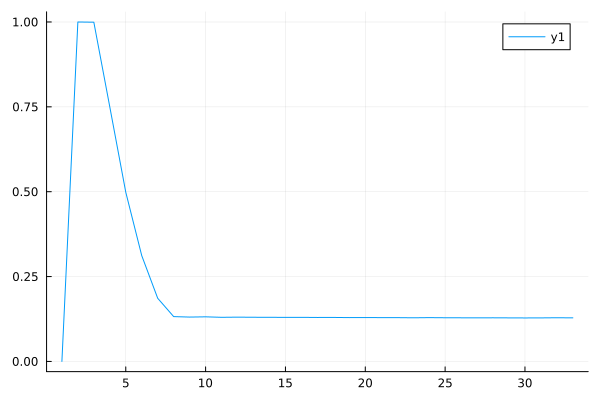

In [72]:
using Plots

plot(S_E)

## (b) Wannier orbitals
- $\ket{\Psi}=P_G\prod_{r=1}^N\zeta_r^\dagger\ket{0}$
- Build maximally localized Wannier orbitals
    - $X=\sum_{j=1}^N\sum_{\alpha=\uparrow,\downarrow}jc_{j\alpha}^\dagger c_{j\alpha}$
    - $\tilde{X}_{mn}=\braket{0|d_mXd_n^\dagger|0}$
    - Diagonalize $\tilde{X}=B\Lambda B^\dagger$
    - The orbital: $\zeta_r^\dagger=\sum_{m=1}^NB_{mr}d_m^\dagger=\sum_{l=1}^{2N}(B^TA)_{rl}c_l^\dagger$
- Represent as MPO: $X=\begin{pmatrix}0&1\end{pmatrix}\prod_j\begin{pmatrix}1&0\\ X_j&1\end{pmatrix}\begin{pmatrix}1\\0\end{pmatrix}$ where $X_j=j(n_\uparrow+n_\downarrow)$
- Unfolding to 2N sites: $X_i=\lceil\frac{i}{2}\rceil n_i$
- J-W trafo: $X_i=\frac{1}{2}\lceil\frac{i}{2}\rceil (1-\sigma^z_i)$

In [61]:
function mpo_to_mps(mps::Vector{Array{Complex, 3}}, mpo::Vector{Array{Complex, 4}})
    result = Vector{Array{Complex, 3}}(undef, length(mps))
    for i in 1:length(mps)
        mps_new = contract(mps[i], [2], mpo[i], [4])
        # combine legs (1, 3) and (2, 5)
        id14 = tn_identity(mps_new, 1, mps_new, 3)
        id23 = tn_identity(mps_new, 2, mps_new, 5)
        mps_new = contract(mps_new, [1, 3], id14, [1, 2])
        mps_new = contract(mps_new, [1, 3], id23, [1, 2])
        result[i] = permutedims(mps_new, (2, 1, 3))
    end
    return result
end

function expectation(mps1::Vector{Array{Complex, 3}}, mps2::Vector{Array{Complex, 3}}, mpo::Vector{Array{Complex, 4}})
    result = reshape([1], (1,1,1))
    for i in 1:length(mps1)
        result = updateLeft(result, mps2[i], mpo[i], mps1[i])
    end
    return result[1, 1, 1]
end

function index_transform(n::Int)
    return k_vec[ceil(Int, n/2)], 1 - mod(n, 2)    
end

index_transform (generic function with 1 method)

- $k_n=k(\lceil n/2\rceil)$
- $\alpha_n=1-\mathrm{mod}_2 n$

In [62]:
X = Vector{Array{Complex, 4}}(undef, 2N)
for i in 1:2N
    X[i] = zeros(Complex, 2, 2, 2, 2)  # MPO for X operator
    X[i][1, :, 1, :] = id # identity operator
    X[i][2, :, 2, :] = id # identity operator
    X[i][2, :, 1, :] = ceil(i/2) / 2 .* (id-sz)
end
X[1] = contract([0 1], [2], X[1], [1])
X[2N] = permutedims(contract(X[2N], [3], [1 0], [2]), (1,2,4,3))

X_mat = Matrix{Complex}(undef, N, N)
for (m, n) in Iterators.product(1:N, 1:N)
    kn, alphan = index_transform(n)
    km, alpham = index_transform(m)
    dn = mpo_to_mps(mps_jw, mpo_dkalpha(kn, alphan, 2N))
    dm = mpo_to_mps(mps_jw, mpo_dkalpha(km, alpham, 2N))
    X_mat[m, n] = expectation(dn, dm, X)
end

In [ ]:
eig = eigen(X_mat)
B = eig.vectors

function wannier(r::Int)
    # r is the index of the Wannier-orbital
    # B is the matrix of eigenvectors from the previous step
    # The Wannier function is given by the r-th column of B
    W_r = Vector{Array{Complex,4}}(undef, 2N)
    W_r[1] = zeros(Complex, 1,2,2,2)
    for i in 2:2N-1
        W_r[i] = zeros(Complex, 2,2,2,2)
    end
    W_r[2N] = zeros(Complex, 2,2,1,2)

    for m in 1:N
        km, alpham = index_transform(m)
        W_r = W_r + B[m, r] .* mpo_dkalpha(km, alpham, 2N)
    end
    return W_r
end

@show wannier(1)[2]  # calculate the first Wannier function

2×2×2×2 Array{ComplexF64, 4}:
[:, :, 1, 1] =
 0.0123322+0.00852543im  0.0+0.0im
       0.0+0.0im         0.0+0.0im

[:, :, 2, 1] =
        0.0+0.0im         0.0+0.0im
 0.00616611+0.00426271im  0.0+0.0im

[:, :, 1, 2] =
          0.0+0.0im          0.0123322+0.00852543im
 -9.54776e-17+1.58185e-16im        0.0+0.0im

[:, :, 2, 2] =
 0.0+0.0im          0.0+0.0im
 0.0+0.0im  -0.00616611-0.00426271im